In [357]:
# within coin_flips.txt contains data of the outcomes 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

In [358]:
df = pd.read_csv('coin_flips.txt', header=None)
df = df[0].str.split(' ', expand=True).astype(int)

In [359]:
# add a new column to the dataframe with the number of heads
df['heads'] = df.sum(axis=1)
print(df['heads'].value_counts())

heads
14    7
19    6
3     5
12    5
11    4
5     4
13    3
18    3
8     3
10    2
15    2
7     2
9     1
2     1
4     1
6     1
Name: count, dtype: int64


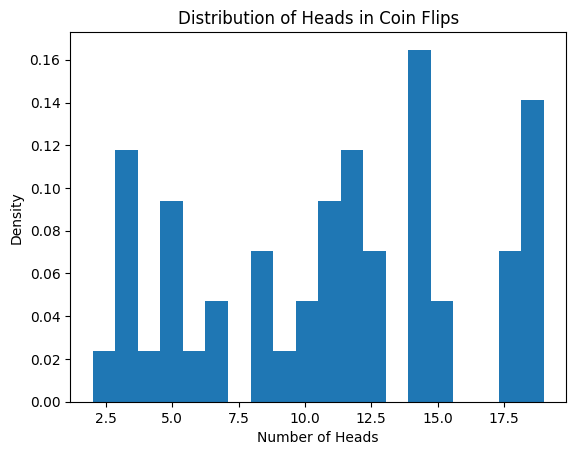

In [360]:
# plot the distribution of heads
plt.hist(df['heads'], bins=20, density=True)
plt.xlabel('Number of Heads')
plt.ylabel('Density')
plt.title('Distribution of Heads in Coin Flips')
plt.show()


In [361]:
# Three coins A,B,C with head-prob p_A, p_B, p_C can be chosen for each of N sessions.
# Once a coin is chosen for the session, that coin is flipped D times.
# For D=20 and N=50, and fixed non-uniform selection coin probabilities pi_A, pi_B, pi_C, which sum to 1, we have this outcome
# each row corresponds to a session with 20 binary 1=head 0=tail.

# probability of picking each coin (sum to 1)
coin_a, coin_b, coin_c = np.random.rand(3)
coin_a, coin_b, coin_c = coin_a / (coin_a + coin_b + coin_c), coin_b / (coin_a + coin_b + coin_c), coin_c / (coin_a + coin_b + coin_c)

# heads biases of the coins
bias_a, bias_b, bias_c = np.random.rand(3)

print(coin_a, coin_b, coin_c)
print(bias_a, bias_b, bias_c)
# Compute the probabilities to select each coin to session (3 mixture "pi" probabilities), and also the bias probabilities (3 param "p" probabilities).

# HINT: for each session, since the D flips are independent of each other, what matters is the number of heads out of the batch size D. If chance of head is p_ for each flip, then probability of observing x heads is binomial(x|p_, D). Here is a technical brief note .
# In English: binomial(X|p_,D) = probability to get x heads out of D coin flips, if coin has head-bias p_.

0.06356796194038762 0.37863885842144585 0.5577931796381664
0.7965553036856551 0.627617058932467 0.9618437871730268


In [362]:
print(df)

    0  1  2  3  4  5  6  7  8  9  ...  11  12  13  14  15  16  17  18  19  \
0   0  1  0  0  1  0  1  0  1  0  ...   0   1   1   1   0   1   1   0   1   
1   1  0  0  1  1  1  1  1  1  1  ...   1   0   0   1   1   1   1   0   1   
2   1  1  0  1  1  1  0  0  1  1  ...   0   0   1   0   1   1   0   1   0   
3   1  0  0  0  0  0  0  0  0  1  ...   0   0   1   0   0   0   0   0   0   
4   0  0  1  0  0  1  0  0  0  1  ...   0   0   0   0   0   0   0   0   0   
5   0  0  1  1  0  0  1  0  1  0  ...   1   0   1   0   1   1   1   1   1   
6   1  1  1  1  1  1  1  1  0  1  ...   1   1   1   1   1   1   1   1   1   
7   1  1  1  0  1  1  0  1  1  1  ...   1   1   0   1   1   0   1   0   0   
8   0  1  0  0  0  1  0  1  0  0  ...   0   0   0   0   0   0   0   1   1   
9   1  1  1  1  1  1  1  1  1  1  ...   1   1   1   1   1   1   1   1   1   
10  1  1  1  1  0  1  1  1  1  1  ...   1   1   1   1   1   1   1   1   1   
11  1  1  1  1  0  1  1  1  0  1  ...   1   1   0   1   0   1   1   0   0   

In [363]:
# 2. binomial probability, n = 20, k = counts of heads
# prob = stats.binom.pmf(10, 20, p_A)
# binomial mixture 
# randomly set memberships of each coin per row
# instead of means and covariances, randomly initialize 

def binomial_mixture(df, k, max_iter=100):
    # parameter initialization
    n = df.shape[0] # 50 sessions
    D = df.shape[1] - 1 # 20 flips, adjusted for adding 'Heads' count column
    
    p = np.random.rand(k) # head bias of each coin
    pi = np.random.rand(k) # probability of picking each coin
    pi /= pi.sum() # normalize to sum to 1

    # memberships
    memberships = np.zeros((n, k))
    for i in range(max_iter):
        # E-step (expectation): assign each session to most likely coin using binomial dist
        for j in range(k):
            memberships[:, j] = pi[j] * stats.binom.pmf(df['heads'], D, p[j])
        memberships /= memberships.sum(axis=1, keepdims=True)
        # M-step: recompute parameters (centroids) using updated memberships
        for j in range(k):
            p[j] = (memberships[:, j] * df['heads']).sum() / (memberships[:, j] * D).sum()
            pi[j] = memberships[:, j].mean()
    return p, pi

p, pi = binomial_mixture(df, 3)
print(p)
print(pi)



[0.61003783 0.23691867 0.93172853]
[0.51462834 0.30681398 0.17855768]


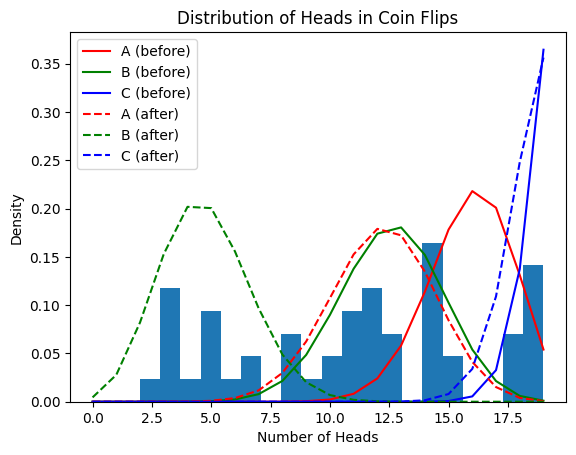

In [364]:
# plot:
x = np.arange(0, 20)
plt.hist(df['heads'], bins=20, density=True)
plt.xlabel('Number of Heads')
plt.ylabel('Density')
plt.title('Distribution of Heads in Coin Flips')
plt.plot(x, stats.binom.pmf(x, 20, bias_a), 'r-', label='A (before)')
plt.plot(x, stats.binom.pmf(x, 20, bias_b), 'g-', label='B (before)')
plt.plot(x, stats.binom.pmf(x, 20, bias_c), 'b-', label='C (before)')
plt.plot(x, stats.binom.pmf(x, 20, p[0]), 'r--', label='A (after)')
plt.plot(x, stats.binom.pmf(x, 20, p[1]), 'g--', label='B (after)')
plt.plot(x, stats.binom.pmf(x, 20, p[2]), 'b--', label='C (after)')
plt.legend()
plt.show()


In [365]:
print(sum(pi))

1.0
